In [4]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=74f29e194513c98a860f8f4f14fdc24bfc6f02c1890ab1e7989c18920a2c156a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev69r0ob/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 2.2MB/s eta 0:00:01
ERROR: mlflow 0.5.0 requires uuid, which is not installed.
  Found existing installation: scikit-learn 0.18.2
    Uninstalling scikit-learn-0.18.2:
      Successfully uninstalled scikit-learn-0.18.2
You should consider upgrading via the 'pip install --upgrade pip' command.


In [58]:
import pandas as pd

pd.__version__

'0.19.2'

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext(appName="Reading Train/Validated data")
sqlContext = SQLContext(sc)

#Provide your Spark-master node below
hostname = "10.128.0.178" 
dbname = "sepsis"
jdbcPort = 3306
username = "sepsis"
password = "Success_2020"
jdbc_url = "jdbc:mysql://{0}:{1}/{2}?user={3}&password={4}".format(hostname,jdbcPort, dbname,username,password)

query = "(select * from train) t1_alias"
train_spark = sqlContext.read.format('jdbc').options(driver = 'com.mysql.jdbc.Driver',url=jdbc_url, dbtable=query ).load()

In [6]:
train = train_spark.select("*").toPandas()

In [7]:
query1 = "(select * from validate) t2_alias"
val_spark = sqlContext.read.format('jdbc').options(driver = 'com.mysql.jdbc.Driver',url=jdbc_url, dbtable=query1).load()

In [8]:
val = val_spark.select("*").toPandas()

In [9]:
val.columns

Index(['PID', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [10]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

In [11]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

    train['custom_temp'].fillna('Missing', inplace=True)
    return train

In [12]:
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <1, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
    return train

In [13]:
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

    train['custom_o2stat'].fillna('Missing', inplace=True)
    return train

In [14]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

    train['custom_bp'].fillna('Missing', inplace=True)
    return train

In [15]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'

    train['custom_resp'].fillna('Missing', inplace=True)


    return train
  

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168686 entries, 0 to 1168685
Data columns (total 42 columns):
PID                 1168686 non-null object
HR                  1168686 non-null object
O2Sat               1168686 non-null object
Temp                1168686 non-null object
SBP                 1168686 non-null object
MAP                 1168686 non-null object
DBP                 1168686 non-null object
Resp                1168686 non-null object
EtCO2               1168686 non-null object
BaseExcess          1168686 non-null object
HCO3                1168686 non-null object
FiO2                1168686 non-null object
pH                  1168686 non-null object
PaCO2               1168686 non-null object
SaO2                1168686 non-null object
AST                 1168686 non-null object
BUN                 1168686 non-null object
Alkalinephos        1168686 non-null object
Calcium             1168686 non-null object
Chloride            1168686 non-null object
Creatin

In [17]:
for feature in train.loc[:, train.columns != 'PID']: 
    if train[feature].dtype == 'object':
        train[feature] = train[feature].astype(float)

In [18]:
train.dtypes

PID                  object
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 

In [19]:
for feature in val.loc[:, val.columns != 'PID']: 
    if val[feature].dtype == 'object':
        val[feature] = val[feature].astype(float)

In [ ]:
for feature in val.loc[:, val.columns != 'PID']: 
    if val[feature].dtype == 'object':
        val[feature] = val[feature].astype(float)

In [20]:
val.dtypes

PID                  object
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Age                 

In [21]:
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)

val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)
val = feature_engineer_resp_rate(val)


In [22]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [23]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

In [24]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


In [44]:
logistic_pipe_scale = make_pipeline(preprocess_trans_scale, 
                                    LogisticRegression(solver='lbfgs') )

scores_logistic_pipe_scale = cross_validate(logistic_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

In [45]:
log_df = pd.DataFrame(scores_logistic_pipe_scale)
log_df['model'] = 'LogisticRegression'

In [46]:
results = pd.concat([log_df])

In [48]:
def score_model(model, metric_list, y_true, y_pred):
    metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
    df = pd.DataFrame()
    df['model'] = [model]
    for metric in metric_list:
        df[metric] = [metric_dict[metric](y_true, y_pred)]
    return df

In [47]:
results

,fit_time,score_time,test_average_precision,test_precision,test_recall,test_roc_auc,model
0,25.891113,3.897837,0.065640,0.208333,0.002686,0.698080,LogisticRegression
1,27.509132,3.876783,0.072160,0.277778,0.004029,0.703554,LogisticRegression
2,19.254263,4.005992,0.069484,0.163462,0.002283,0.707822,LogisticRegression


In [26]:
log_pipe_scale = make_pipeline(preprocess_trans_scale, 
                               LogisticRegression(C=0.01, solver = 'lbfgs',
                                                  dual=False) )

log_model = log_pipe_scale.fit(X_train, y_train)

In [50]:
log_model = logistic_pipe_scale.fit(X_train, y_train)

In [52]:
df = pd.DataFrame(logistic_pipe_scale.predict_proba(X_train))

df['actual'] = y_val
df.loc[(df[1] >=0.1), 'pred'] = 1 
df.loc[(df[1] <0.1), 'pred'] = 0 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from keras.layers import Dense, Input, regularizers
#from keras.models import Model, Sequential
#from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import lightgbm as lgb
import seaborn as sns
from subprocess import call
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [35]:
!pip install lightgbm

     |████████████████████████████████| 1.8MB 2.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
!pip install keras

You should consider upgrading via the 'pip install --upgrade pip' command.


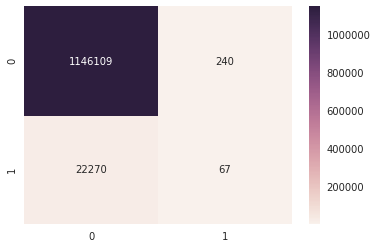

In [55]:
pred = logistic_pipe_scale.predict(X_train)
conf_matrix = confusion_matrix(y_train, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [57]:
score_model('Logistic_regression', ['recall','precision', 'avg_precision'],
            y_train, pred)

,model,recall,precision,avg_precision
0,Logistic_regression,0.003,0.218241,0.01971


In [39]:
eval_df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

eval_df['actual'] = y_val

def eval_threshold(eval_df, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        eval_df.loc[(eval_df[1] >=threshold), 'pred'] = 1 
        eval_df.loc[(eval_df[1] <threshold), 'pred'] = 0 
        avg_pre_list.append(average_precision_score(eval_df['actual'], 
                                                    eval_df['pred']))
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(eval_df, list(np.arange(0,1,0.05)))

In [40]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for logistic regression')

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [41]:
import pickle
pickle.dump(log_model, open('final_prediction.pickle', 'wb'))

In [43]:
train[filtered_columns]

,Gender,custom_hr,custom_temp,custom_age,custom_o2stat,custom_bp,custom_resp,ICULOS,HospAdmTime
0,0.0,Missing,Missing,old,Missing,Missing,Missing,1.0,-0.03
1,0.0,normal,Missing,old,normal,Missing,normal,2.0,-0.03
2,0.0,normal,Missing,old,normal,Missing,abnormal,3.0,-0.03
3,0.0,normal,Missing,old,normal,Missing,abnormal,4.0,-0.03
4,0.0,abnormal,Missing,old,abnormal,Missing,abnormal,5.0,-0.03
5,0.0,abnormal,Missing,old,normal,Missing,abnormal,6.0,-0.03
6,0.0,abnormal,abnormal,old,normal,Missing,abnormal,7.0,-0.03
7,0.0,abnormal,Missing,old,normal,Missing,abnormal,8.0,-0.03
8,0.0,abnormal,Missing,old,normal,Missing,abnormal,9.0,-0.03
9,0.0,abnormal,Missing,old,normal,Missing,abnormal,10.0,-0.03
